# Crime Rate Prediction

## Knowing the Dataset's Origin

We are provided with the Dataset from UCI Machine Repository: Communities and Crime Data Set.
You can access the properly oriented Dataset here: https://github.com/sujayrittikar/datasets/blob/main/communities_data.txt

The Dataset has various factors which impact the Crime Rates in the North American region.



*   There are total 128 Attributes in the Dataset
*   All values are already normalized using equal interval binning. So, the scaling here is not an issue.
*   Here is the information of Attributes: https://github.com/sujayrittikar/datasets/blob/main/communities.txt



## Knowing the Problem

The problem here is as the title says, "Crime Rate Prediction" provided we have some important features of the possibilities of the Crime from the Dataset.
In the provided Dataset, we are provided the Violent Crimes per Population(capita), we need to predict it on the basis of important factors.

# Importing the Dataset

In [ ]:
from google.colab import files

In [ ]:
upload = files.upload()

Saving communities_data.txt to communities_data.txt


# Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt   
import matplotlib.style
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from random import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the Dataset

In [ ]:
df = pd.read_csv("communities_data.txt")

# Checking the Dimensions of Data

In [ ]:

df.shape

(1994, 128)

# Inspecting the Dataset

In [ ]:
df.head()

state county  ... PolicBudgPerPop ViolentCrimesPerPop
0      8      ?  ...            0.14                0.20
1     53      ?  ...               ?                0.67
2     24      ?  ...               ?                0.43
3     34      5  ...               ?                0.12
4     42     95  ...               ?                0.03

[5 rows x 128 columns]

### Observations:



*   communityname, community, state, county, fold are categorical variables, mostly all encoded
*   All others are numerical variables and need to be explored on the basis of their meaning and relativity with our outputs



## Basic Information about the Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(26)
memory usage: 1.9+ MB


In [ ]:
df.to_csv('df.csv', index=False, header=True)

### We can't know the data as there are too many columns to consider. So, let's evaluate the data types for all columns.

In [ ]:
for i in df.columns:
    print("Column " + i + ": " + str(df[i].dtype))

Column state: int64
Column county: object
Column community: object
Column communityname: object
Column fold: int64
Column population: float64
Column householdsize: float64
Column racepctblack: float64
Column racePctWhite: float64
Column racePctAsian: float64
Column racePctHisp: float64
Column agePct12t21: float64
Column agePct12t29: float64
Column agePct16t24: float64
Column agePct65up: float64
Column numbUrban: float64
Column pctUrban: float64
Column medIncome: float64
Column pctWWage: float64
Column pctWFarmSelf: float64
Column pctWInvInc: float64
Column pctWSocSec: float64
Column pctWPubAsst: float64
Column pctWRetire: float64
Column medFamInc: float64
Column perCapInc: float64
Column whitePerCap: float64
Column blackPerCap: float64
Column indianPerCap: float64
Column AsianPerCap: float64
Column OtherPerCap: object
Column HispPerCap: float64
Column NumUnderPov: float64
Column PctPopUnderPov: float64
Column PctLess9thGrade: float64
Column PctNotHSGrad: float64
Column PctBSorMore: flo

### Observations: 
* Almost all data values are float and some categorical variables represent object type.
* Some object variables may need to be converted to numerical considering their importance and evaluation for the prediction.

In [ ]:
df.describe(include='all')

state county  ... PolicBudgPerPop ViolentCrimesPerPop
count   1994.000000   1994  ...            1994         1994.000000
unique          NaN    109  ...              52                 NaN
top             NaN      ?  ...               ?                 NaN
freq            NaN   1174  ...            1675                 NaN
mean      28.683551    NaN  ...             NaN            0.237979
std       16.397553    NaN  ...             NaN            0.232985
min        1.000000    NaN  ...             NaN            0.000000
25%       12.000000    NaN  ...             NaN            0.070000
50%       34.000000    NaN  ...             NaN            0.150000
75%       42.000000    NaN  ...             NaN            0.330000
max       56.000000    NaN  ...             NaN            1.000000

[11 rows x 128 columns]

### Observations:

* Since almost all the data variables are normalized, we won't need to concern about their normalization.
* A few variables such as state, county, community, communityname need to be scaled if they prove to be predictive.

# Filtering our variables:

* Our predictions shouldn't consider the race or heritage or language as a factor, so we need to filter those variables out before moving on to EDA except a single factor:
  * RacialMatchCommPol: a measure of the racial match between the community and the police force. High values indicate proportions in community and police force are similar
* We need to drop the column, fold since it's just the cross-validation fold. We will cross validate our dataset later on according to the processing.
* We won't consider any variables related to police officers. The reason being we need to focus on the prediction of crime rate on the basis of tendency of person to commit the crime rather than what are the post-crime conditions. Thus, not to ignore the possibility so we'll consider just a few important variables: 
    * LemasSwFTFieldOps: number of sworn full time police officers in field operations (on the street as opposed to administrative etc)
    * LemasSwFTFieldPerPop: sworn full time police officers in field operations (on the street as opposed to administrative etc) per 100K population
    * OfficAssgnDrugUnits: number of officers assigned to special drug units
    * PolicAveOTWorked: police average overtime worked


# EDA Related Data Pre-Processing

In [ ]:
df_eda = df.drop(['fold', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'LemasSwornFT', 'LemasSwFTPerPop',  'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'NumKindsDrugsSeiz', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop'], axis=1)

In [ ]:
df_eda.head()

state county community  ... PopDens  PctUsePubTrans  ViolentCrimesPerPop
0      8      ?         ?  ...    0.26            0.20                 0.20
1     53      ?         ?  ...    0.12            0.45                 0.67
2     24      ?         ?  ...    0.21            0.02                 0.43
3     34      5     81440  ...    0.39            0.28                 0.12
4     42     95      6096  ...    0.09            0.02                 0.03

[5 rows x 97 columns]

In [ ]:
df_eda.shape

(1994, 97)

In [ ]:
duplicates = df_eda.duplicated()
duplicates.sum()

0

No duplicates thus, we can move on with the important Analysis of our Dataset

# Important Variables to be considered for Analysis:

1. Population: population for community
2. Household Size: mean people per household
3. pctUrban: percentage of people living in areas classified as urban
4. medIncome: median household income
5. medFamInc: median family income (differs from household income for non-family households)
6. perCapInc: per capita income
7. PctPopUnderPov: percentage of people under the poverty level
8. PctUnemployed: percentage of people 16 and over, in the labor force, and unemployed
9. PctKids2Par: percentage of kids in family housing with two parents
10. PctIlleg: percentage of kids born to never married
11. PctImmigRecent: percentage of _immigrants_ who immigated within last 3 years
12. PctRecentImmig: percent of _population_ who have immigrated within the last 3 years
13. HousVacant: number of vacant households
14. RentLowQ: rental housing - lower quartile rent
15. RentHighQ: rental housing - upper quartile rent
PctForeignBorn: percent of people foreign born
16. PctBornSameState: percent of people born in the same state as currently living
17. PopDens: population density in persons per square mile
18. RacialMatchCommPol: a measure of the racial match between the community and the police force
19. LemasSwFTFieldOps: number of sworn full time police officers in field operations (on the street as opposed to administrative etc)
20. OfficAssgnDrugUnits: number of officers assigned to special drug units
21. PolicAveOTWorked: police average overtime worked


# **Univariate Graphical Analysis of Important Variables**

## Check Frequency Distributions for scaled intervals for all variables


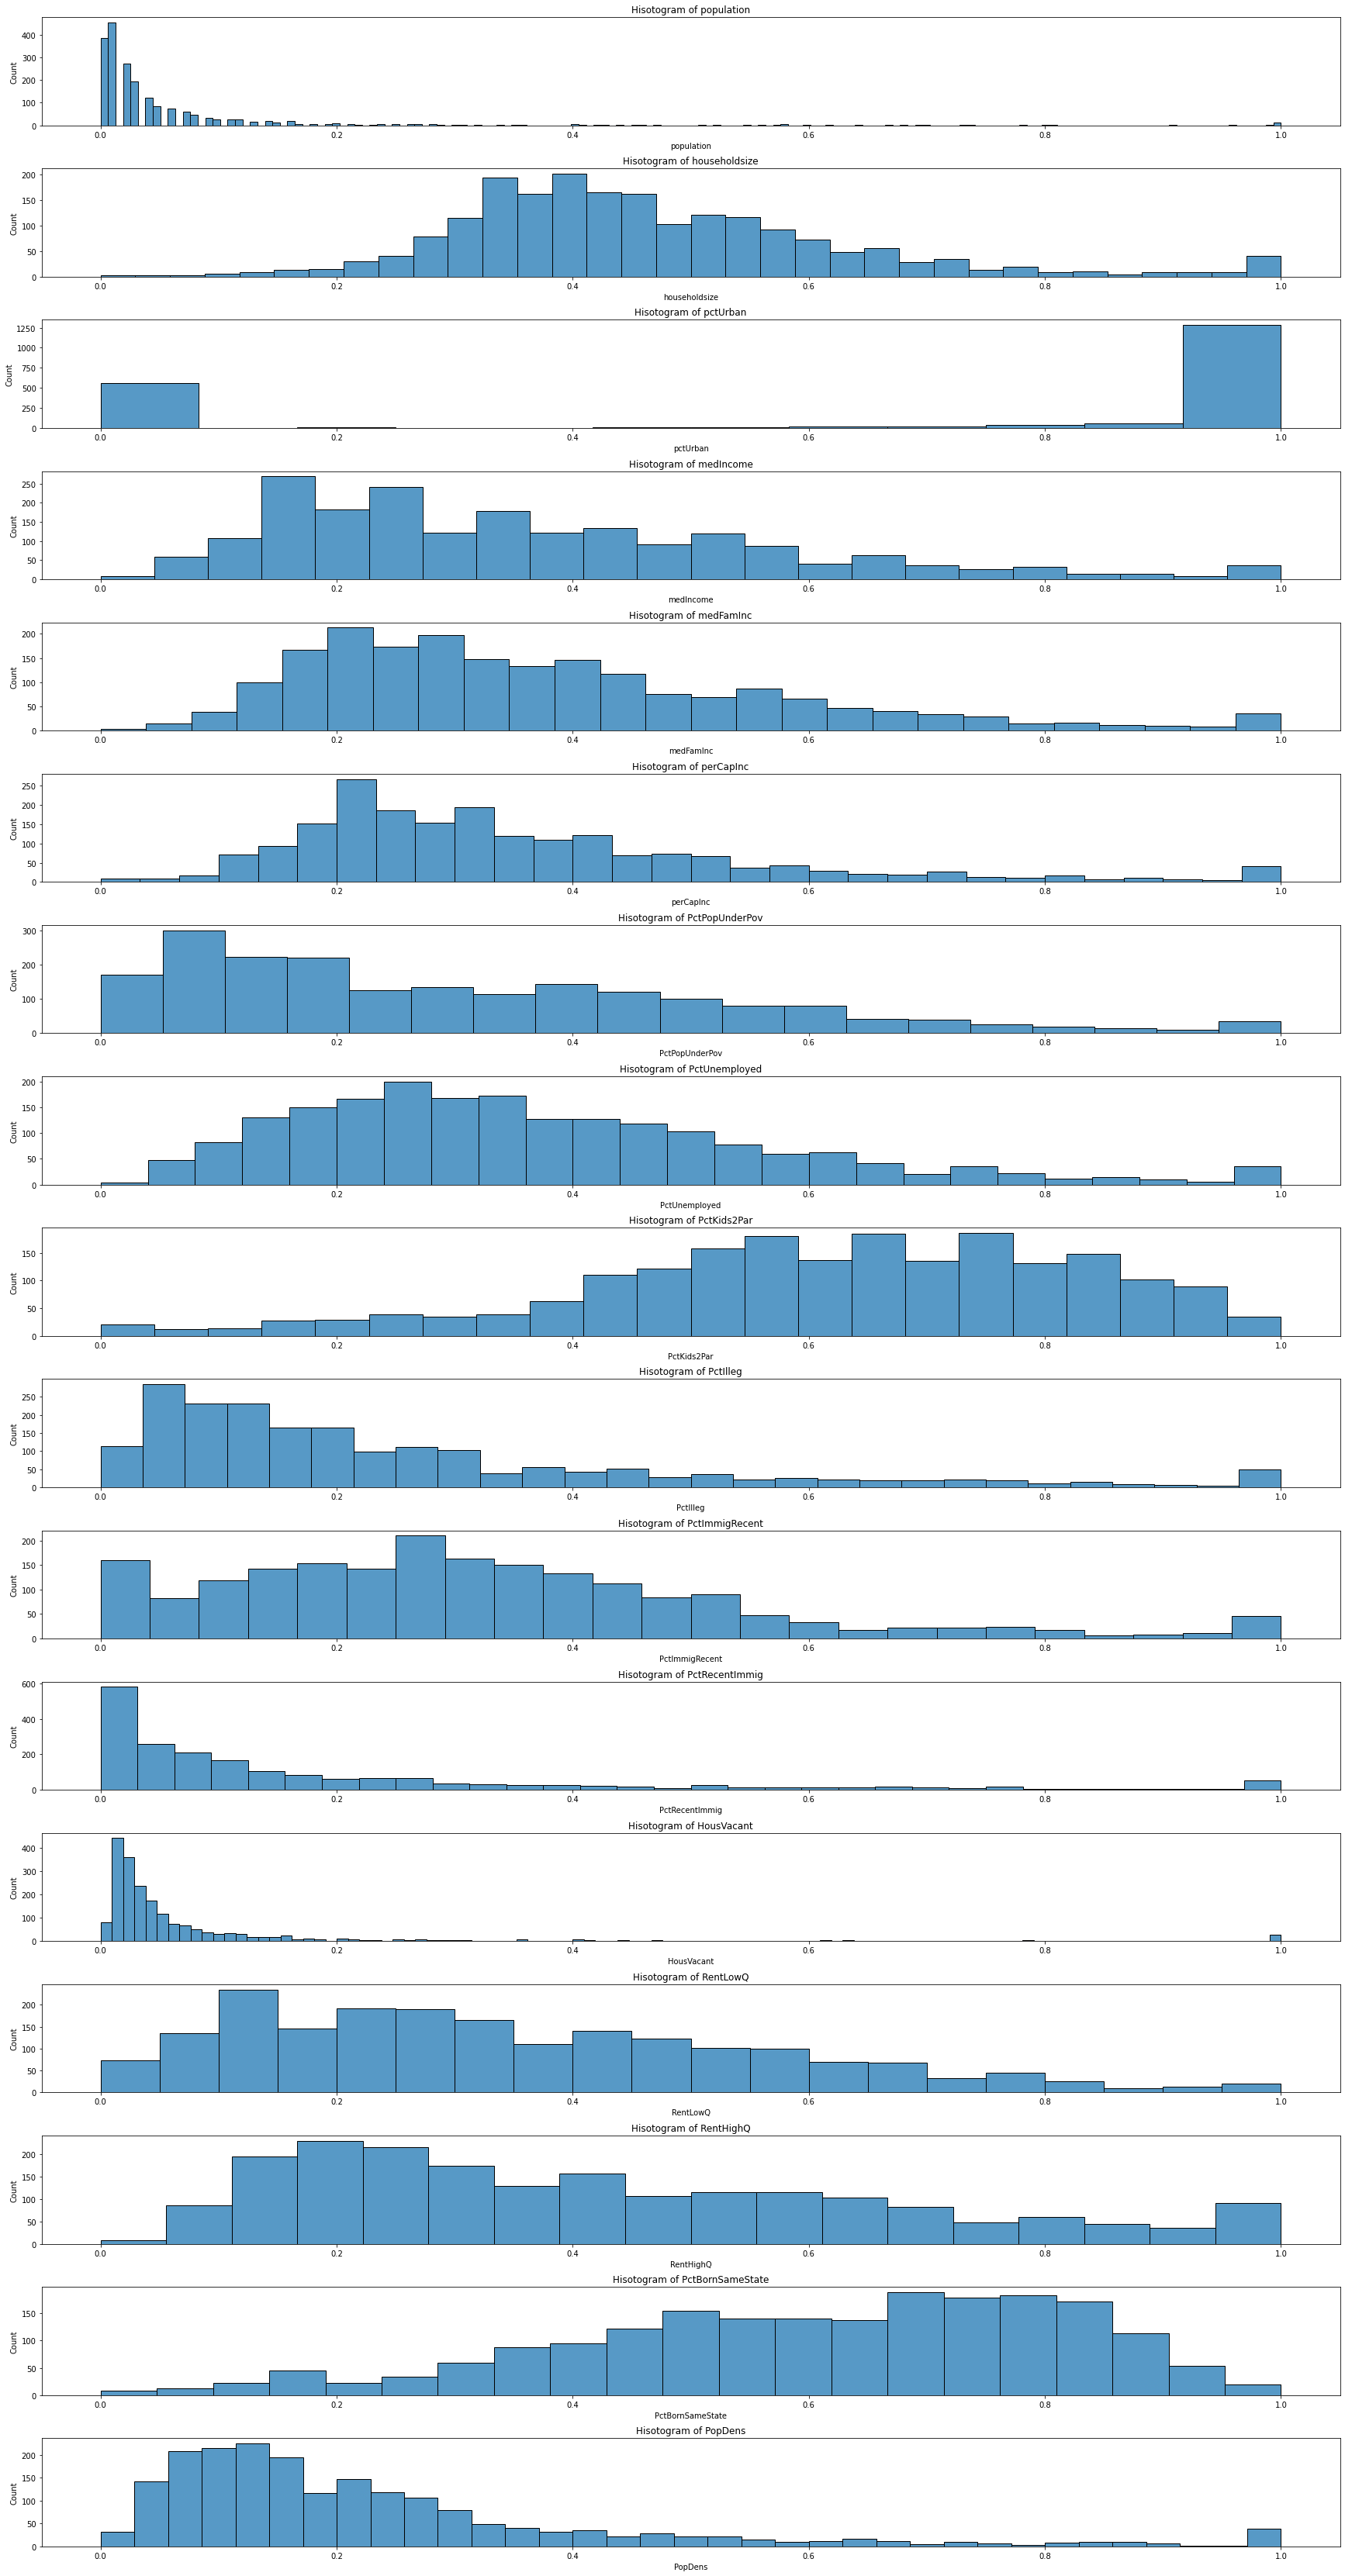

In [ ]:
columns = ['population', 'householdsize', 'pctUrban', 'medIncome', 'medFamInc', 'perCapInc', 'PctPopUnderPov', 'PctUnemployed', 'PctKids2Par', 'PctIlleg', 'PctImmigRecent', 'PctRecentImmig', 'HousVacant', 'RentLowQ', 'RentHighQ', 'PctBornSameState', 'PopDens']
fig, axes = plt.subplots(nrows=17,ncols=1,  figsize=(30, 60))
fig.subplots_adjust(hspace = .4, wspace=.2)
i = 0

for col in columns:
  sns.histplot(df_eda[col], ax=axes[i]).set_title("Hisotogram of " + col)
  i = i + 1

## Observations
* Most of the Data points in our Dataset have low populations as most of them fall under the scaled range of 0.0 and 0.1.
It highlights the fact that our Dataset has most of the information about the low populated areas. So, population can't be considered a predictive concern yet, can be considered for further Analysis or Hypothesis Testing on some questions.

* Most Data points contain the average Household size, not too big, not too small based on the scales of 0.3-0.65 nearly.

* Most of the Data points conclude that there is either a very high percentage of Urban population or very low percentage of Urban population, considering the most frequent scales of 0.0-0.1 and 0.9-1.0. Thus affirming, that 

* The median Incomes of Data points are right tailed, i.e., most frequently, the median Income values fall just below 0.2 and below 0.6. This showcases that most Data points portray low to moderate range Incomes and a fewer high median Incomes.

* The median Family Incomes show a very relative Data points with respect to the median Income values, most frequently the median Family Incomes fall from just over 0.2 to around 0.6 which is lower to moderate ranges.

* The per Capita Incomes again showcase similar trend and values to the median Incomes and median Family Incomes. Most likely, because these are all related. Thus, if we have to consider the best measure among these 3, we will consider per Capita Income as this measure represents a more diverse sets of Incomes.
The values for per Capita Incomes are more frequent between 0.2 and 0.6 which is again low to moderate levels.

* Most Data points have a very low to moderate percentages of Population under Poverty, i.e., 0.0 to 0.6. Poverty may or may not be a factor to commit crime as it's likely to consider that people might commit crimes to feed themselves but it's also important to perform analysis on these possibilities before building any particular inferences.

* Unemployement Percentages though, display a slightly varying inference compared to the Percentages of Population under Poverty. The Unemployment Percentages have a high variability with most frequent Data points ranging from 0.1 to around 0.7 Unemployment Percentages. Although, these Percentages may not represent the Unemployment Percentages of a whole Population compared to a sample the Data point will represent. They might stand a bit misleading while performing Analysis but again, should be considered and filtered out as Unemployment still stands as an important factors when we consider crimes.

* Percentages of kids in family housing with 2 parents are most frequent for moderate to high percentages which actually highlights a positive inference that most kids have 2 parents in the Data points we have. Although again, this just represents the data of Family housing and not the overall housing so, we can't be highly affirmitive that other considerations are particularly valid. Yet, this factor is effective and might correlate with regions with higher crime rates. We'll test this in Bi-variate Analysis.

* Percentage of kids born to Unmarried couples are relatively less frequent in the Data which again, doesn't lead to conclusions just yet. But, for now we can assume that this data might prove to show a trend among the kids. As we saw for the factor of percentages of kids in family with 2 parents, the lower percentage populations might actually have the higher percentages of kids born to unmarried couples. It's highly likely that these 2 variables will also correlate with each other.

* The higher frequencies of Immigrants who immigrated recently have low to moderate percentages meaning that there are low to moderate percentage of total immigrants who immigrated recently.

* The high frequencies of recent Immigrants with respect to the whole population represent very low percentage to scaled values. This concludes to the fact that there are very less people who actually immigrated recently compared to the total immigrants.

* The variable HousVacant suggests that most houses are occupied and most data points represent low percentages of houses being vacant.

* The higher quartile and lower quartile of house rents don't suggest a very specific pattern but do highlight a few lows and highs for some particular intervals which might stand as informative. We'll have to conduct analysis relative to other parameters to consider any more inferences.

* The Percentage Born Same State variable suggests that most of the data points represent moderate to high percentage of population born in the same state which might stand as an important factor considering what effect same state or fleeing different state have on the mind of a person commiting the crime.

* Lastly, the Population Density variable suggests that most data points have low population densities thus stating that most regions we have in dataset have lower population compared to the area they live in.



## Check Outliers for these 17 Variables using Boxplots

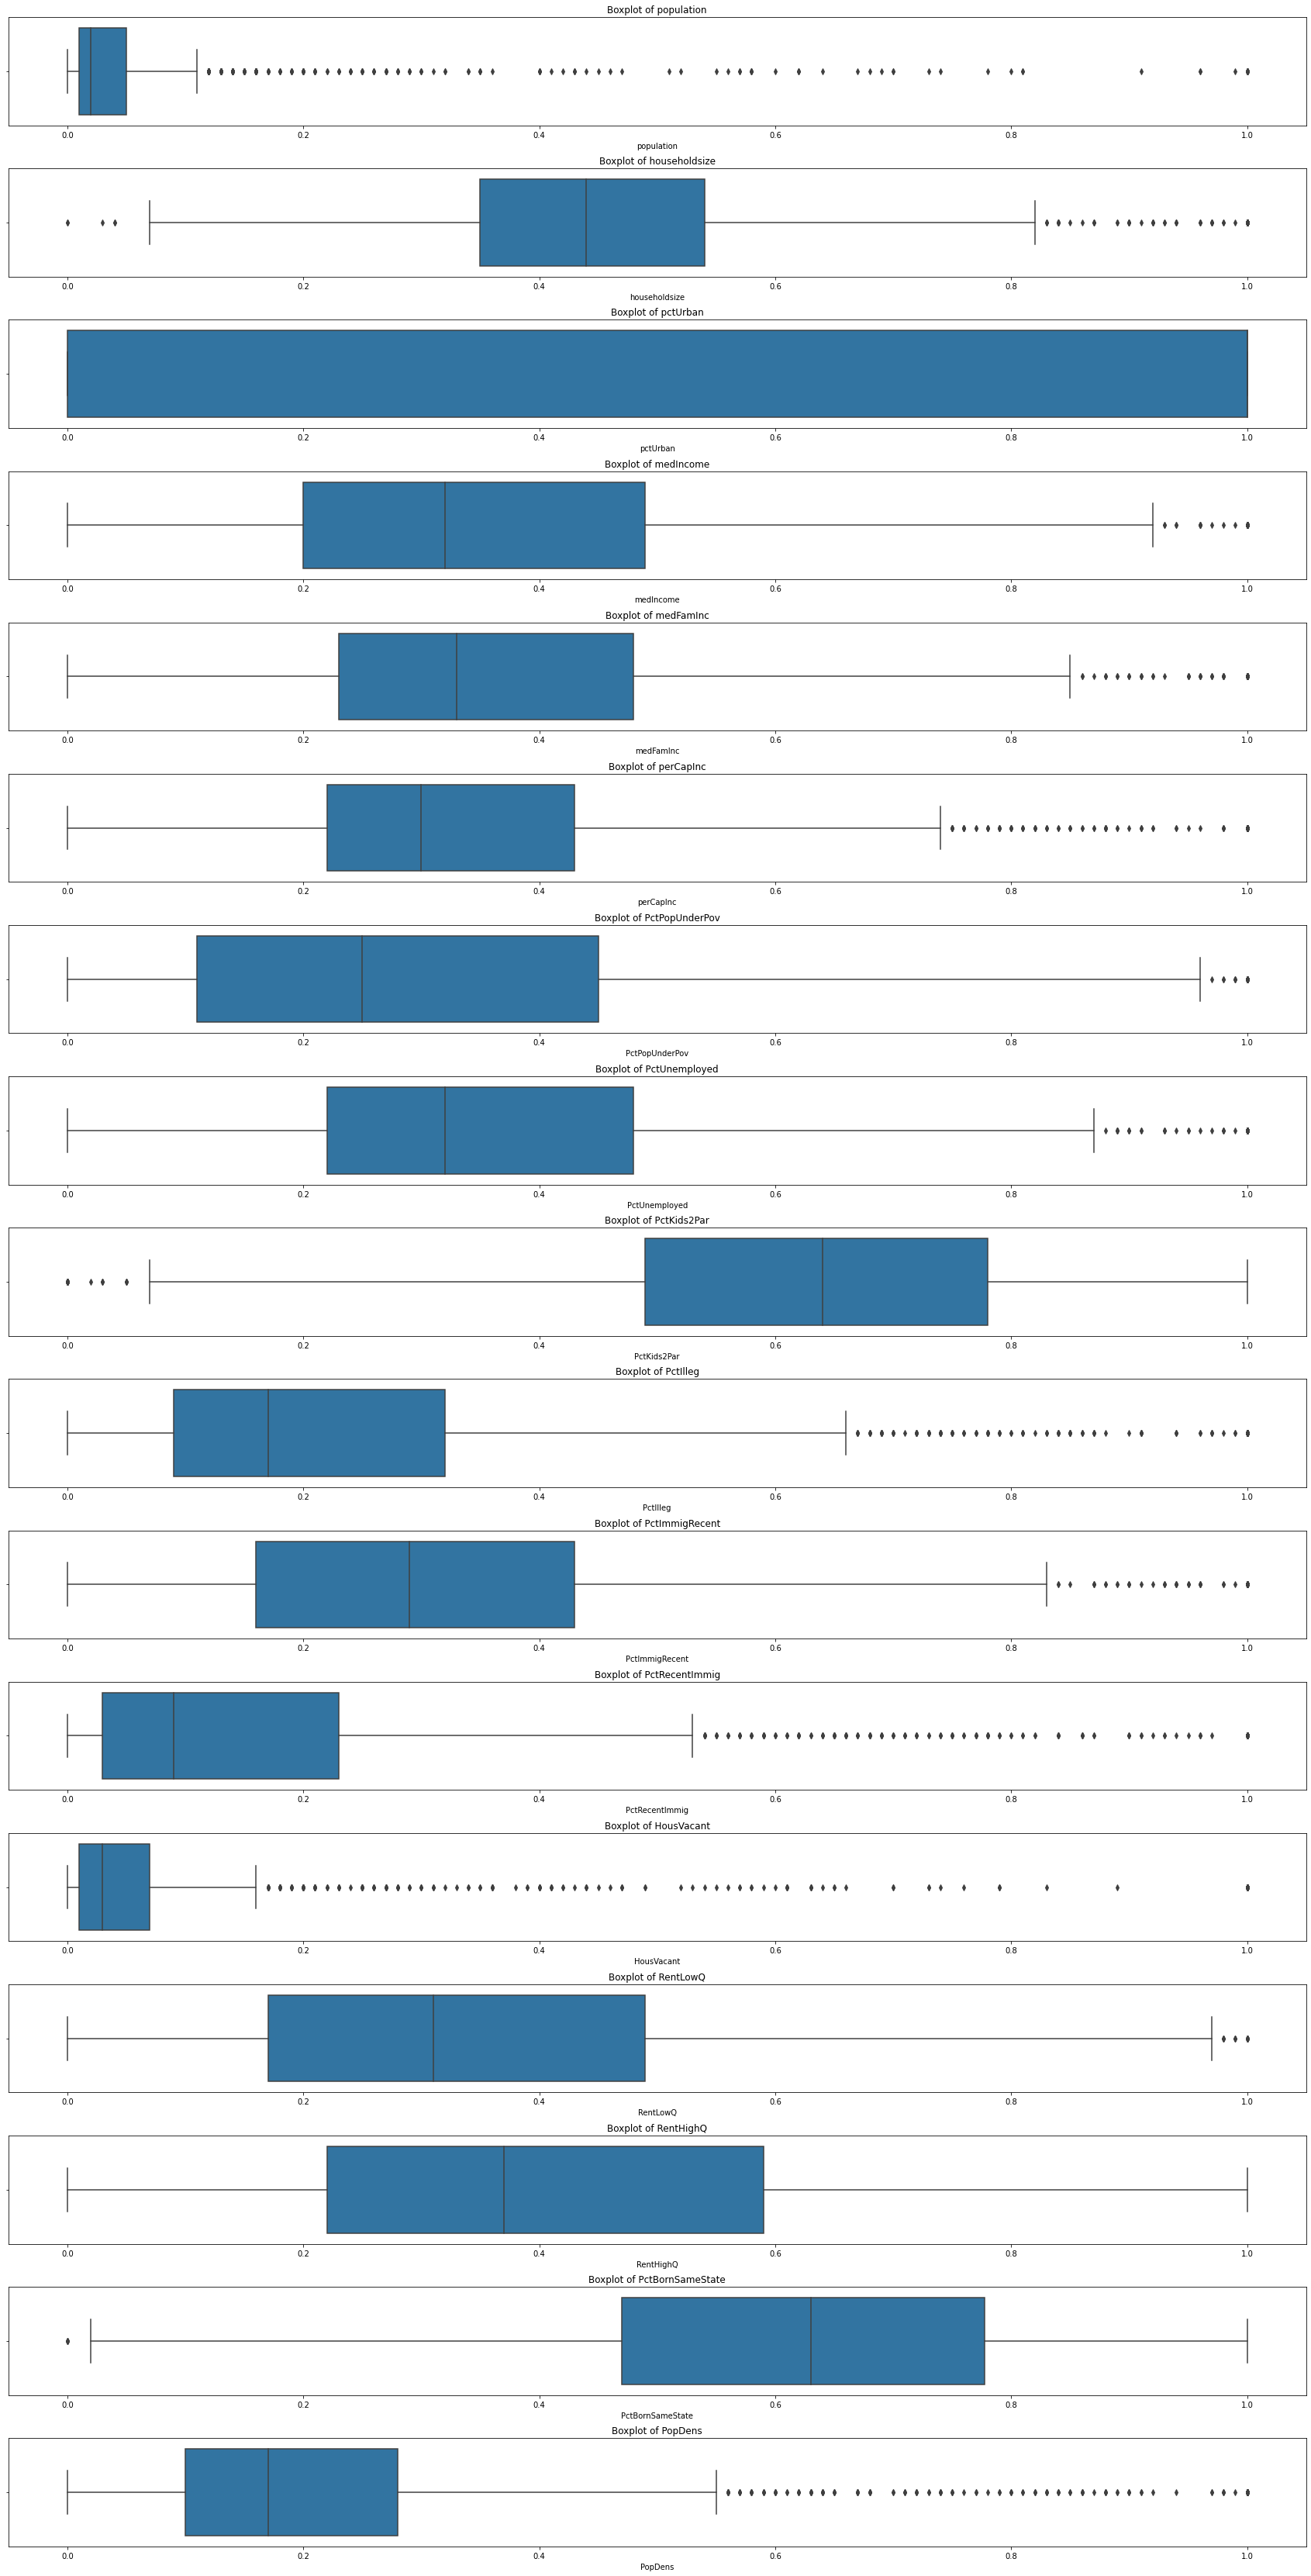

In [ ]:
columns = ['population', 'householdsize', 'pctUrban', 'medIncome', 'medFamInc', 'perCapInc', 'PctPopUnderPov', 'PctUnemployed', 'PctKids2Par', 'PctIlleg', 'PctImmigRecent', 'PctRecentImmig', 'HousVacant', 'RentLowQ', 'RentHighQ', 'PctBornSameState', 'PopDens']
fig, axes = plt.subplots(nrows=17,ncols=1,  figsize=(30, 60))
fig.subplots_adjust(hspace = .4, wspace=.2)
i = 0

for col in columns:
  sns.boxplot(x=df_eda[col], ax=axes[i]).set_title("Boxplot of " + col)
  i = i + 1

## Outlier Observations:

* The Boxplot of population suggests that there are a very high level of outliers so it depicts that, even though the population scales considered in the dataset are mostly in between 0.0 and 0.1, the number of outliers or, the variability of the data is high towards the right side, like a right tailed distribution we observed above.
* The householdsize scales have little to a moderate level of outliers. Most outliers are towards the right end i.e., Q3 + 1.5*IQR. Although the overall Boxplot is much stable and concludes similar outcomes like the Histogram distribution.
* The Boxplot of pctUrban is quite misleading since it covers the whole range but if we observe the distribution, we can see that most values are extreme scales like 0.0 to 0.1 and 0.9 to 1.0.
* medIncome has less number of outliers and follows the conclusions we had through it's Histogram distribution too.
* medFamInc also has decently low amount of outliers and does follow the conclusions we arrived to from the distribution.
* perCapInc has some outliers and they're more spread out as well as it doesn't have it's median value at the centre of the two whiskers.
* PctpopUnderPov has very less outliers and is a stable feature considering the observations from it's distribution.
* pctUnemployed again, has much lesser amount of outliers and can be considered a good predictor feature.
* pctKids2Par also stands as a possibly good predictive feature as it has very less outliers and a proper structure.
* The PctIllegal and PctRecentImmig have moderate to high amount of outliers.
* The PctImmigRecent stands a good predictive feature with low number of outliers.
* The feature HouseVacant has a lot of outliers and represents a bad predictive power.
* The RentLowQ and RentHighQ are strong features with proper median values and very low outliers.
* The feature PctBornSameState has almost no outliers so it should be considered for further Analysis.
* The PopDens has too many outliers to be considered and thus showcases the high amount of variability of the Population Densities in the Data.

## Checking Outlier Percentages

In [ ]:
# Number of outliers
num_vars = ['population', 'householdsize', 'pctUrban', 'medIncome', 'medFamInc', 'perCapInc', 'PctPopUnderPov', 'PctUnemployed', 'PctKids2Par', 'PctIlleg', 'PctImmigRecent', 'PctRecentImmig', 'HousVacant', 'RentLowQ', 'RentHighQ', 'PctBornSameState', 'PopDens']

def convert_to_numeric(col):
  result = df_eda[col].str.split().str[0]
  result = result.replace(to_replace = 'null', value = str(0))
  result = result.replace(to_replace='Null', value=str(0))
  col_mean = np.nanmean(pd.to_numeric(result), axis=0)
  result = result.replace(to_replace=np.nan, value=str(col_mean))
  result = result.replace(to_replace = '?', value = str(col_mean))
  a = pd.to_numeric(result).values
  return a

def outlier_check(n):
  for col in num_vars:
    flag = 0
    if (df_eda[col].dtype =='int64') or (df_eda[col].dtype =='float64'):
      temp = df_eda[col]
    else:
      temp = convert_to_numeric(col) 
      flag=1     
    if flag==0:
      Q1 = temp.quantile(0.25)
      Q3 = temp.quantile(0.75)
    else:
      Q1 = np.quantile(temp, 0.25)
      Q3 = np.quantile(temp, 0.75)
    IQR = Q3 - Q1
    lower_range= Q1-(n * IQR)
    upper_range= Q3+(n * IQR)
    print(col)
    if flag==0:
      print("Number of outliers:",df_eda[(df_eda[col] > upper_range) | (df_eda[col] < lower_range)].shape[0])
      print("Percentage of outliers:{0:10.3f}".format(((df_eda[(df_eda[col] > upper_range) | (df_eda[col] < lower_range)].shape[0])/df_eda.shape[0])*100),"%\n")
    else:
      print("Number of outliers:", len([temp[i] for i in range(len(temp)) if (temp[i]>upper_range or temp[i]<lower_range)]))
      print("Percentage of outliers: {0:10.3f}".format(len([temp[i] for i in range(len(temp)) if (temp[i]>upper_range or temp[i]<lower_range)])/len(temp)*100), "%\n")

In [ ]:
outlier_check(1.5)

population
Number of outliers: 218
Percentage of outliers:    10.933 %

householdsize
Number of outliers: 84
Percentage of outliers:     4.213 %

pctUrban
Number of outliers: 0
Percentage of outliers:     0.000 %

medIncome
Number of outliers: 40
Percentage of outliers:     2.006 %

medFamInc
Number of outliers: 60
Percentage of outliers:     3.009 %

perCapInc
Number of outliers: 106
Percentage of outliers:     5.316 %

PctPopUnderPov
Number of outliers: 31
Percentage of outliers:     1.555 %

PctUnemployed
Number of outliers: 52
Percentage of outliers:     2.608 %

PctKids2Par
Number of outliers: 24
Percentage of outliers:     1.204 %

PctIlleg
Number of outliers: 157
Percentage of outliers:     7.874 %

PctImmigRecent
Number of outliers: 71
Percentage of outliers:     3.561 %

PctRecentImmig
Number of outliers: 197
Percentage of outliers:     9.880 %

HousVacant
Number of outliers: 186
Percentage of outliers:     9.328 %

RentLowQ
Number of outliers: 17
Percentage of outliers:     0

#### Observations:
* Almost all the attributes have low amount of outlers except for the Population, HousVacant, PctRecentImmig, PctIlleg and PopDens. We need to futher check if we can perform imputations before totally filtering out the data.
But, we need to skip a few variables for further analysis: population and pctUrban.

In [ ]:
df_filtered = df_eda[['householdsize', 'medIncome', 'medFamInc', 'perCapInc', 'PctPopUnderPov', 'PctUnemployed', 'PctKids2Par', 'PctIlleg', 'PctImmigRecent', 'PctRecentImmig', 'HousVacant', 'RentLowQ', 'RentHighQ', 'PctBornSameState', 'PopDens', 'ViolentCrimesPerPop']]

# Analysis on Special Variables

Before moving forward with the variables we have obtained, let's consider the variables related to the factors we haven't considered in our predictions and just find out some insights on how they reflect or affect the predictions.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


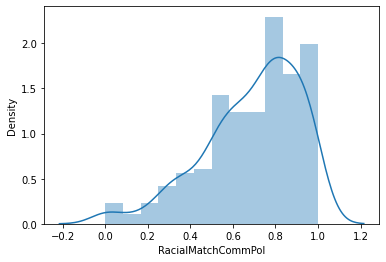

In [ ]:
sns.distplot(df[df['RacialMatchCommPol']!='?']['RacialMatchCommPol'])

#### Interestingly, the Distribution showcases that the density of same race of Police with the criminal is high. Let's check on it more.

In [ ]:
racial_match_comm = df[df['RacialMatchCommPol']!='?']

In [ ]:
racial_match_comm['RacialMatchCommPol'] = racial_match_comm['RacialMatchCommPol'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
racial_match_comm['RacialMatchCommPol'].dtype

dtype('float64')

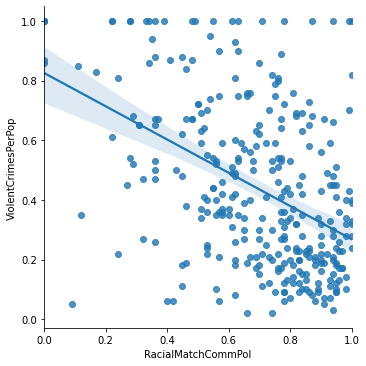

In [ ]:
sns.lmplot(x='RacialMatchCommPol', y='ViolentCrimesPerPop', data=racial_match_comm)

### Although we found it really interesting that the Racial Match between the Police and the Criminal might be a factor considering the fact that the distribution showcases such theory but, the Crime Rates don't depict the same. Thus, it contradicts our Analysis on this variable.

## Let's check the same for LemasSwFTFieldOps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


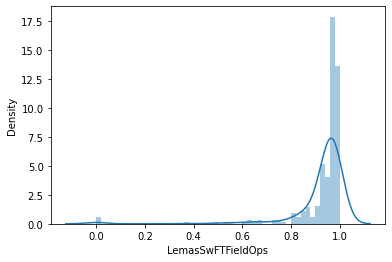

In [ ]:
sns.distplot(df[df['LemasSwFTFieldOps']!='?']['LemasSwFTFieldOps'])

#### Again, this showcases that there were very high amount of Sworn in Officers during the Crime. But, does it infer that it's the reason for high crime rate? That'd be interestingly weird. Let's check if it's true or false.

In [ ]:
lemas_sw_ft_fieldops = df[df['LemasSwFTFieldOps']!='?']

In [ ]:
lemas_sw_ft_fieldops['LemasSwFTFieldOps'] = lemas_sw_ft_fieldops['LemasSwFTFieldOps'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


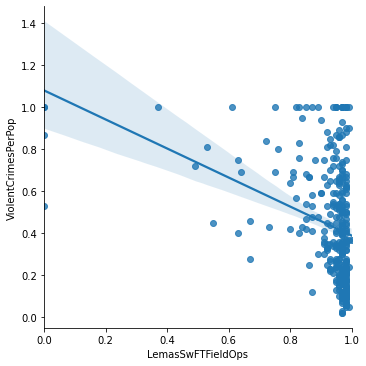

In [ ]:
sns.lmplot(x='LemasSwFTFieldOps', y='ViolentCrimesPerPop', data=lemas_sw_ft_fieldops)

### Unfortunately, even this variable has no particular impact on the predictions. The reason being, the Sworn in Police officers are present at all times, no matter the crime as we can see their scales are very high for even high rates of crimes or low rates of crimes. Even if a few data points exist, we can't say that it's a predictive variable.

## Let's check OfficAssgnDrugUnits

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


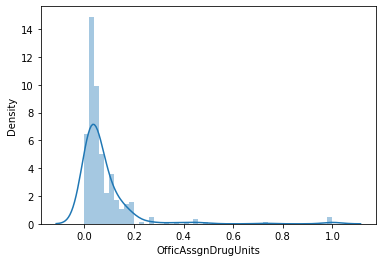

In [ ]:
sns.distplot(df[df['OfficAssgnDrugUnits']!='?']['OfficAssgnDrugUnits'])

#### The distribution suggests that in the most cases, the number of officers assigned to Drug Special Units are less. Let's check if this inference stands in accordance wtih the Crime Rate

In [ ]:
OfficAssgnDrugUnits = df[df['OfficAssgnDrugUnits']!='?']

In [ ]:
OfficAssgnDrugUnits['OfficAssgnDrugUnits'] = OfficAssgnDrugUnits['OfficAssgnDrugUnits'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


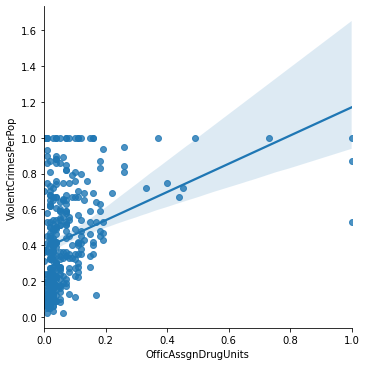

In [ ]:
sns.lmplot(x='OfficAssgnDrugUnits', y='ViolentCrimesPerPop', data=OfficAssgnDrugUnits)

#### Sadly, even this inference is fails because of the reason that in almost all the cases, no matter if the crime rate is high or even 0.0, the number of officers assigned to Special Drug Units are less.

## PolicAveOTWorked

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


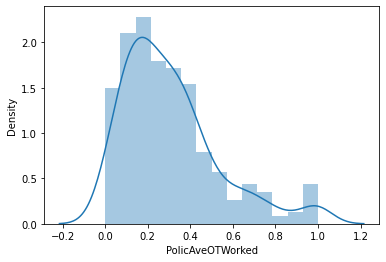

In [ ]:
sns.distplot(df[df['PolicAveOTWorked']!='?']['PolicAveOTWorked'])

#### The distribution doesn't suggest a particular possible inference since the Average Overtime Worked is distributed along 0.0 to 0.5.

In [ ]:
PolicAveOTWorked = df[df['PolicAveOTWorked']!='?']

In [ ]:
PolicAveOTWorked['PolicAveOTWorked'] = PolicAveOTWorked['PolicAveOTWorked'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


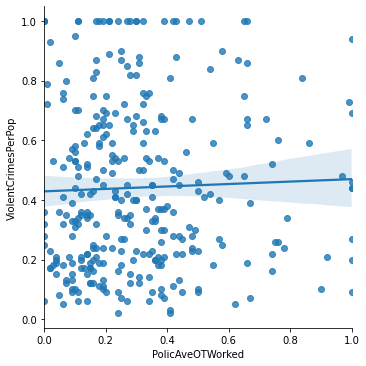

In [ ]:
sns.lmplot(x='PolicAveOTWorked', y='ViolentCrimesPerPop', data=PolicAveOTWorked)

#### Also, there's no particular correlation between the variable and Crime Rates

## Conclusion:

We can't consider any of these special variables for our prediction or futher analysis since there is no particular correlation found.

## Proceeding back with the filtered dataset

# Bi-Variate Analysis

#### Check relationship among the Continuous Variables using Pairplot

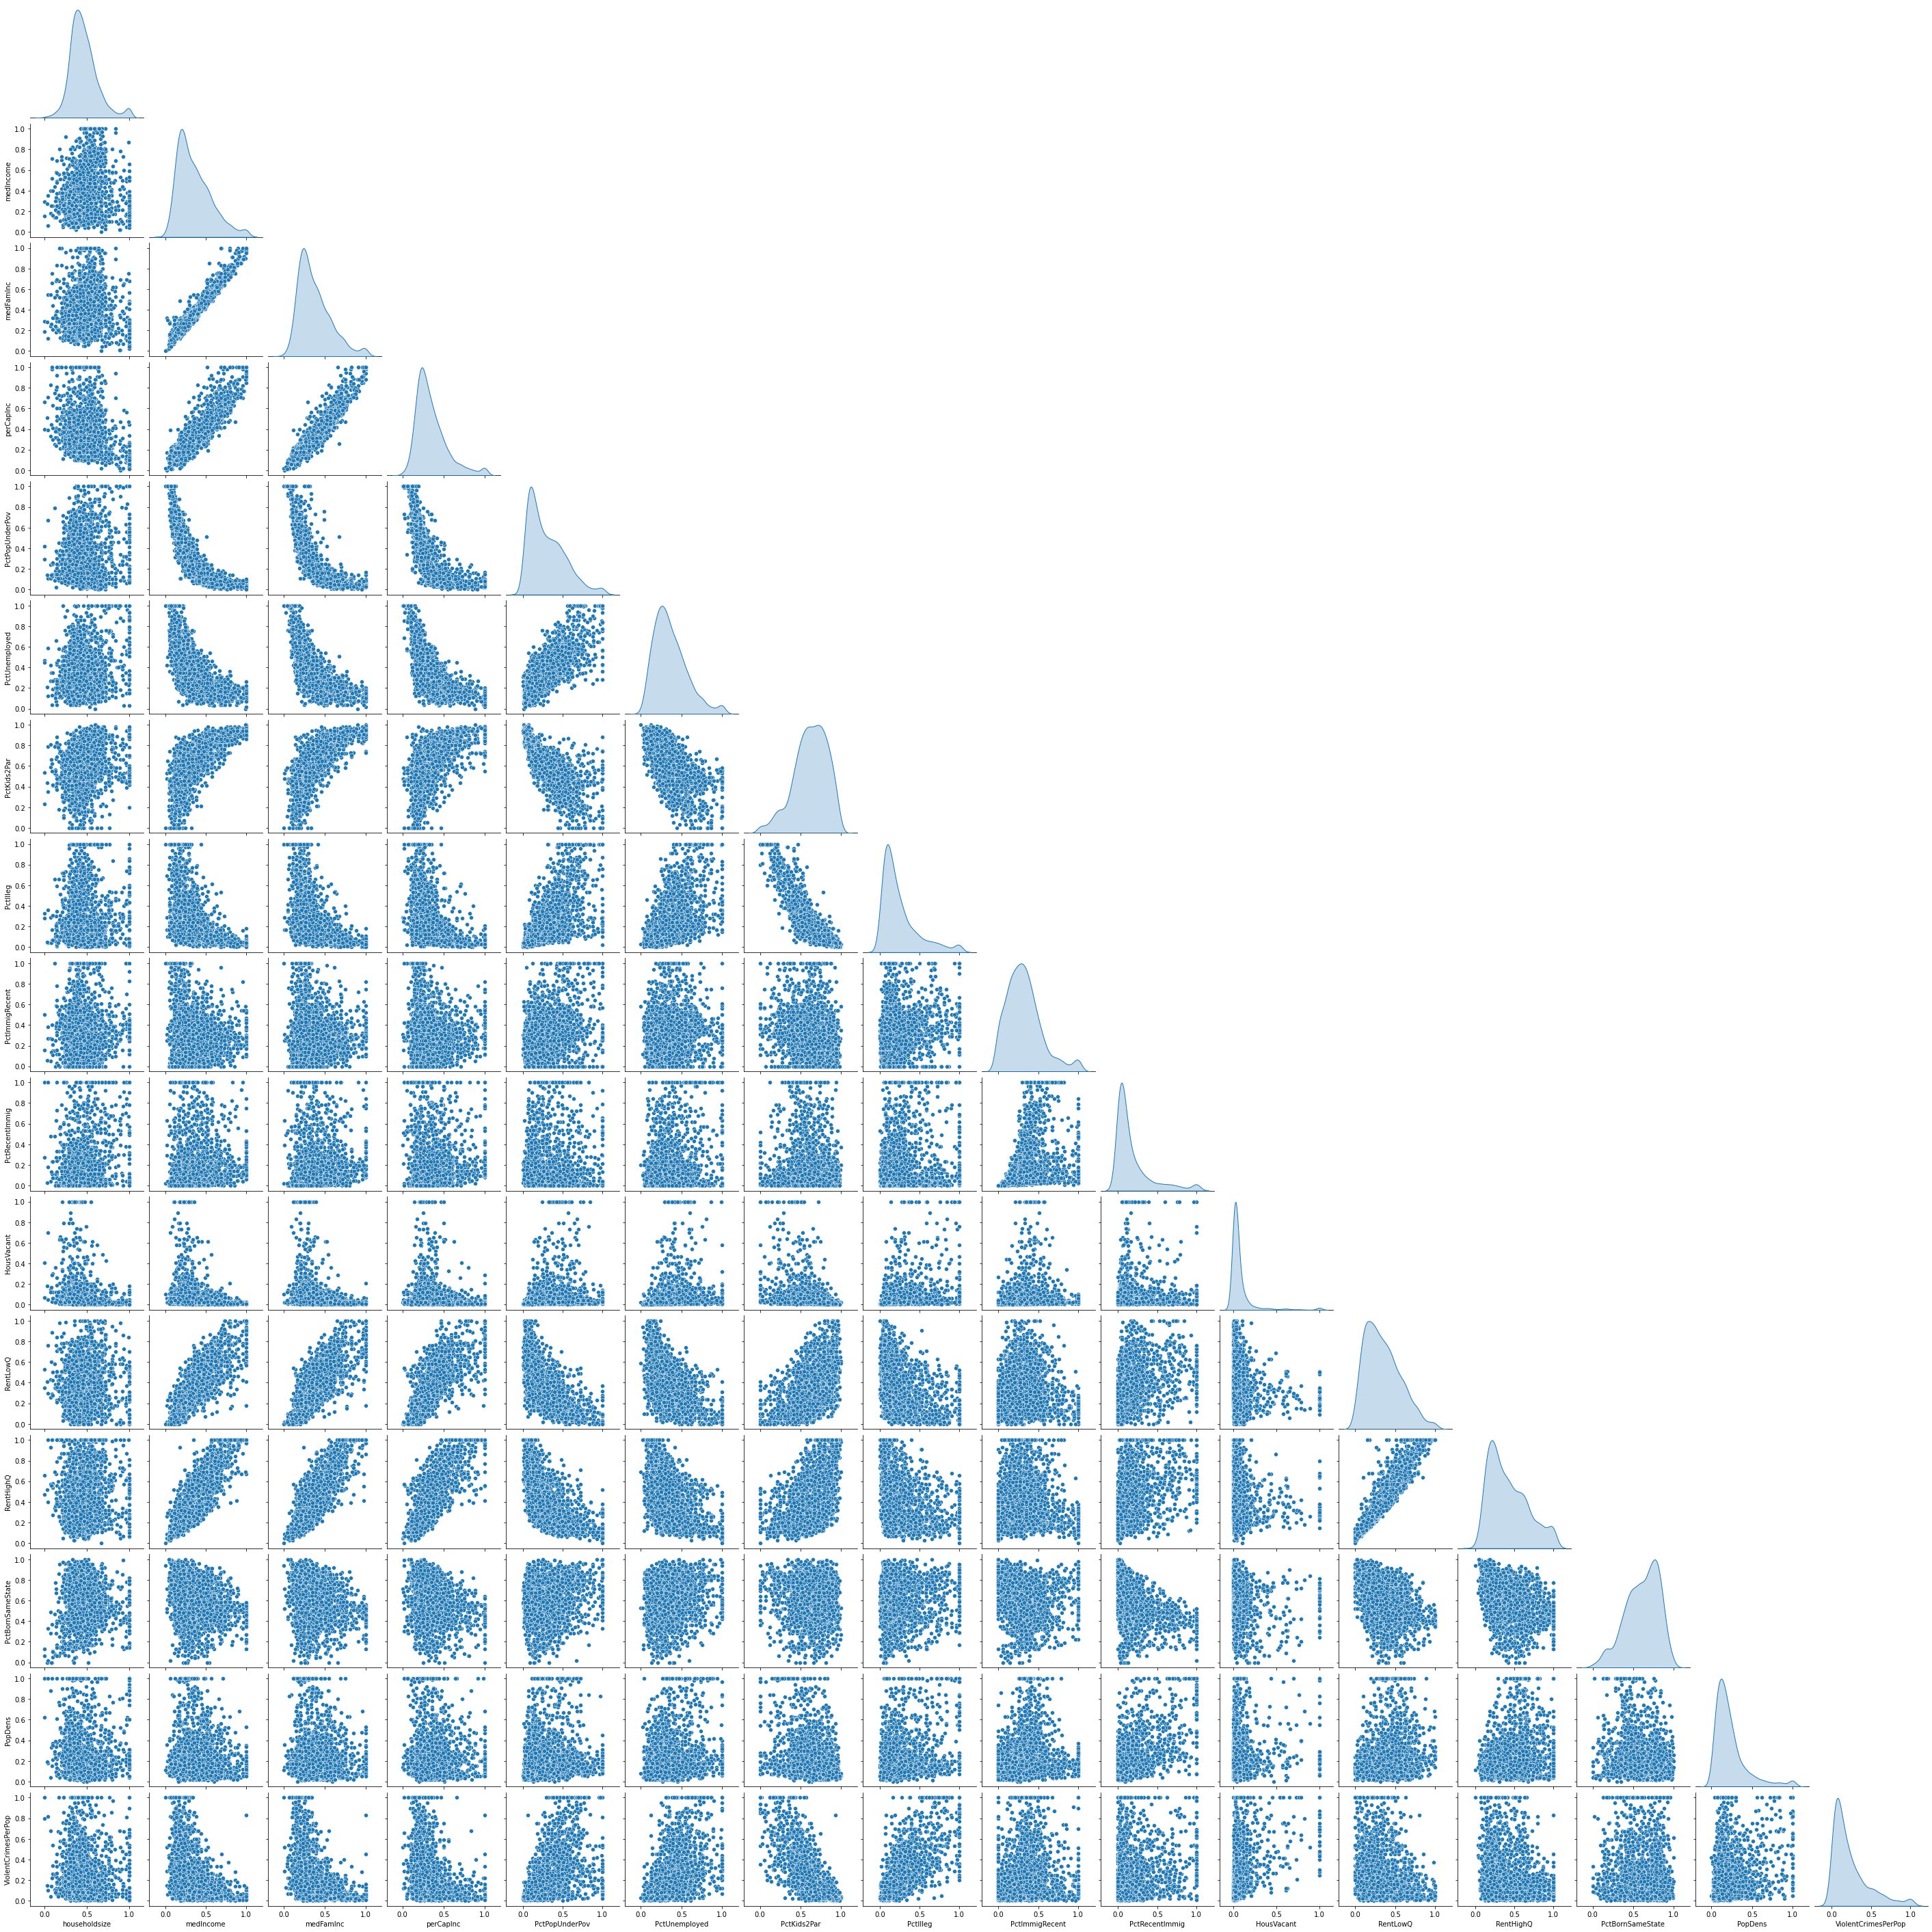

In [ ]:
sns.pairplot(data=df_filtered, corner=True, diag_kind='kde')

## Observations:

* We can observe a lot of multicollinearity, for example: RentHighQ with perCapInc, medFamInc, medIncome, RentLowQ, which is for some obvious reasons.
* In terms of ViolentCrimesPerPop only a few variables like PctKids2Par and PctIlleg seem to have a observable correlation.

#### Checking the Correlation Values with a Heatmap

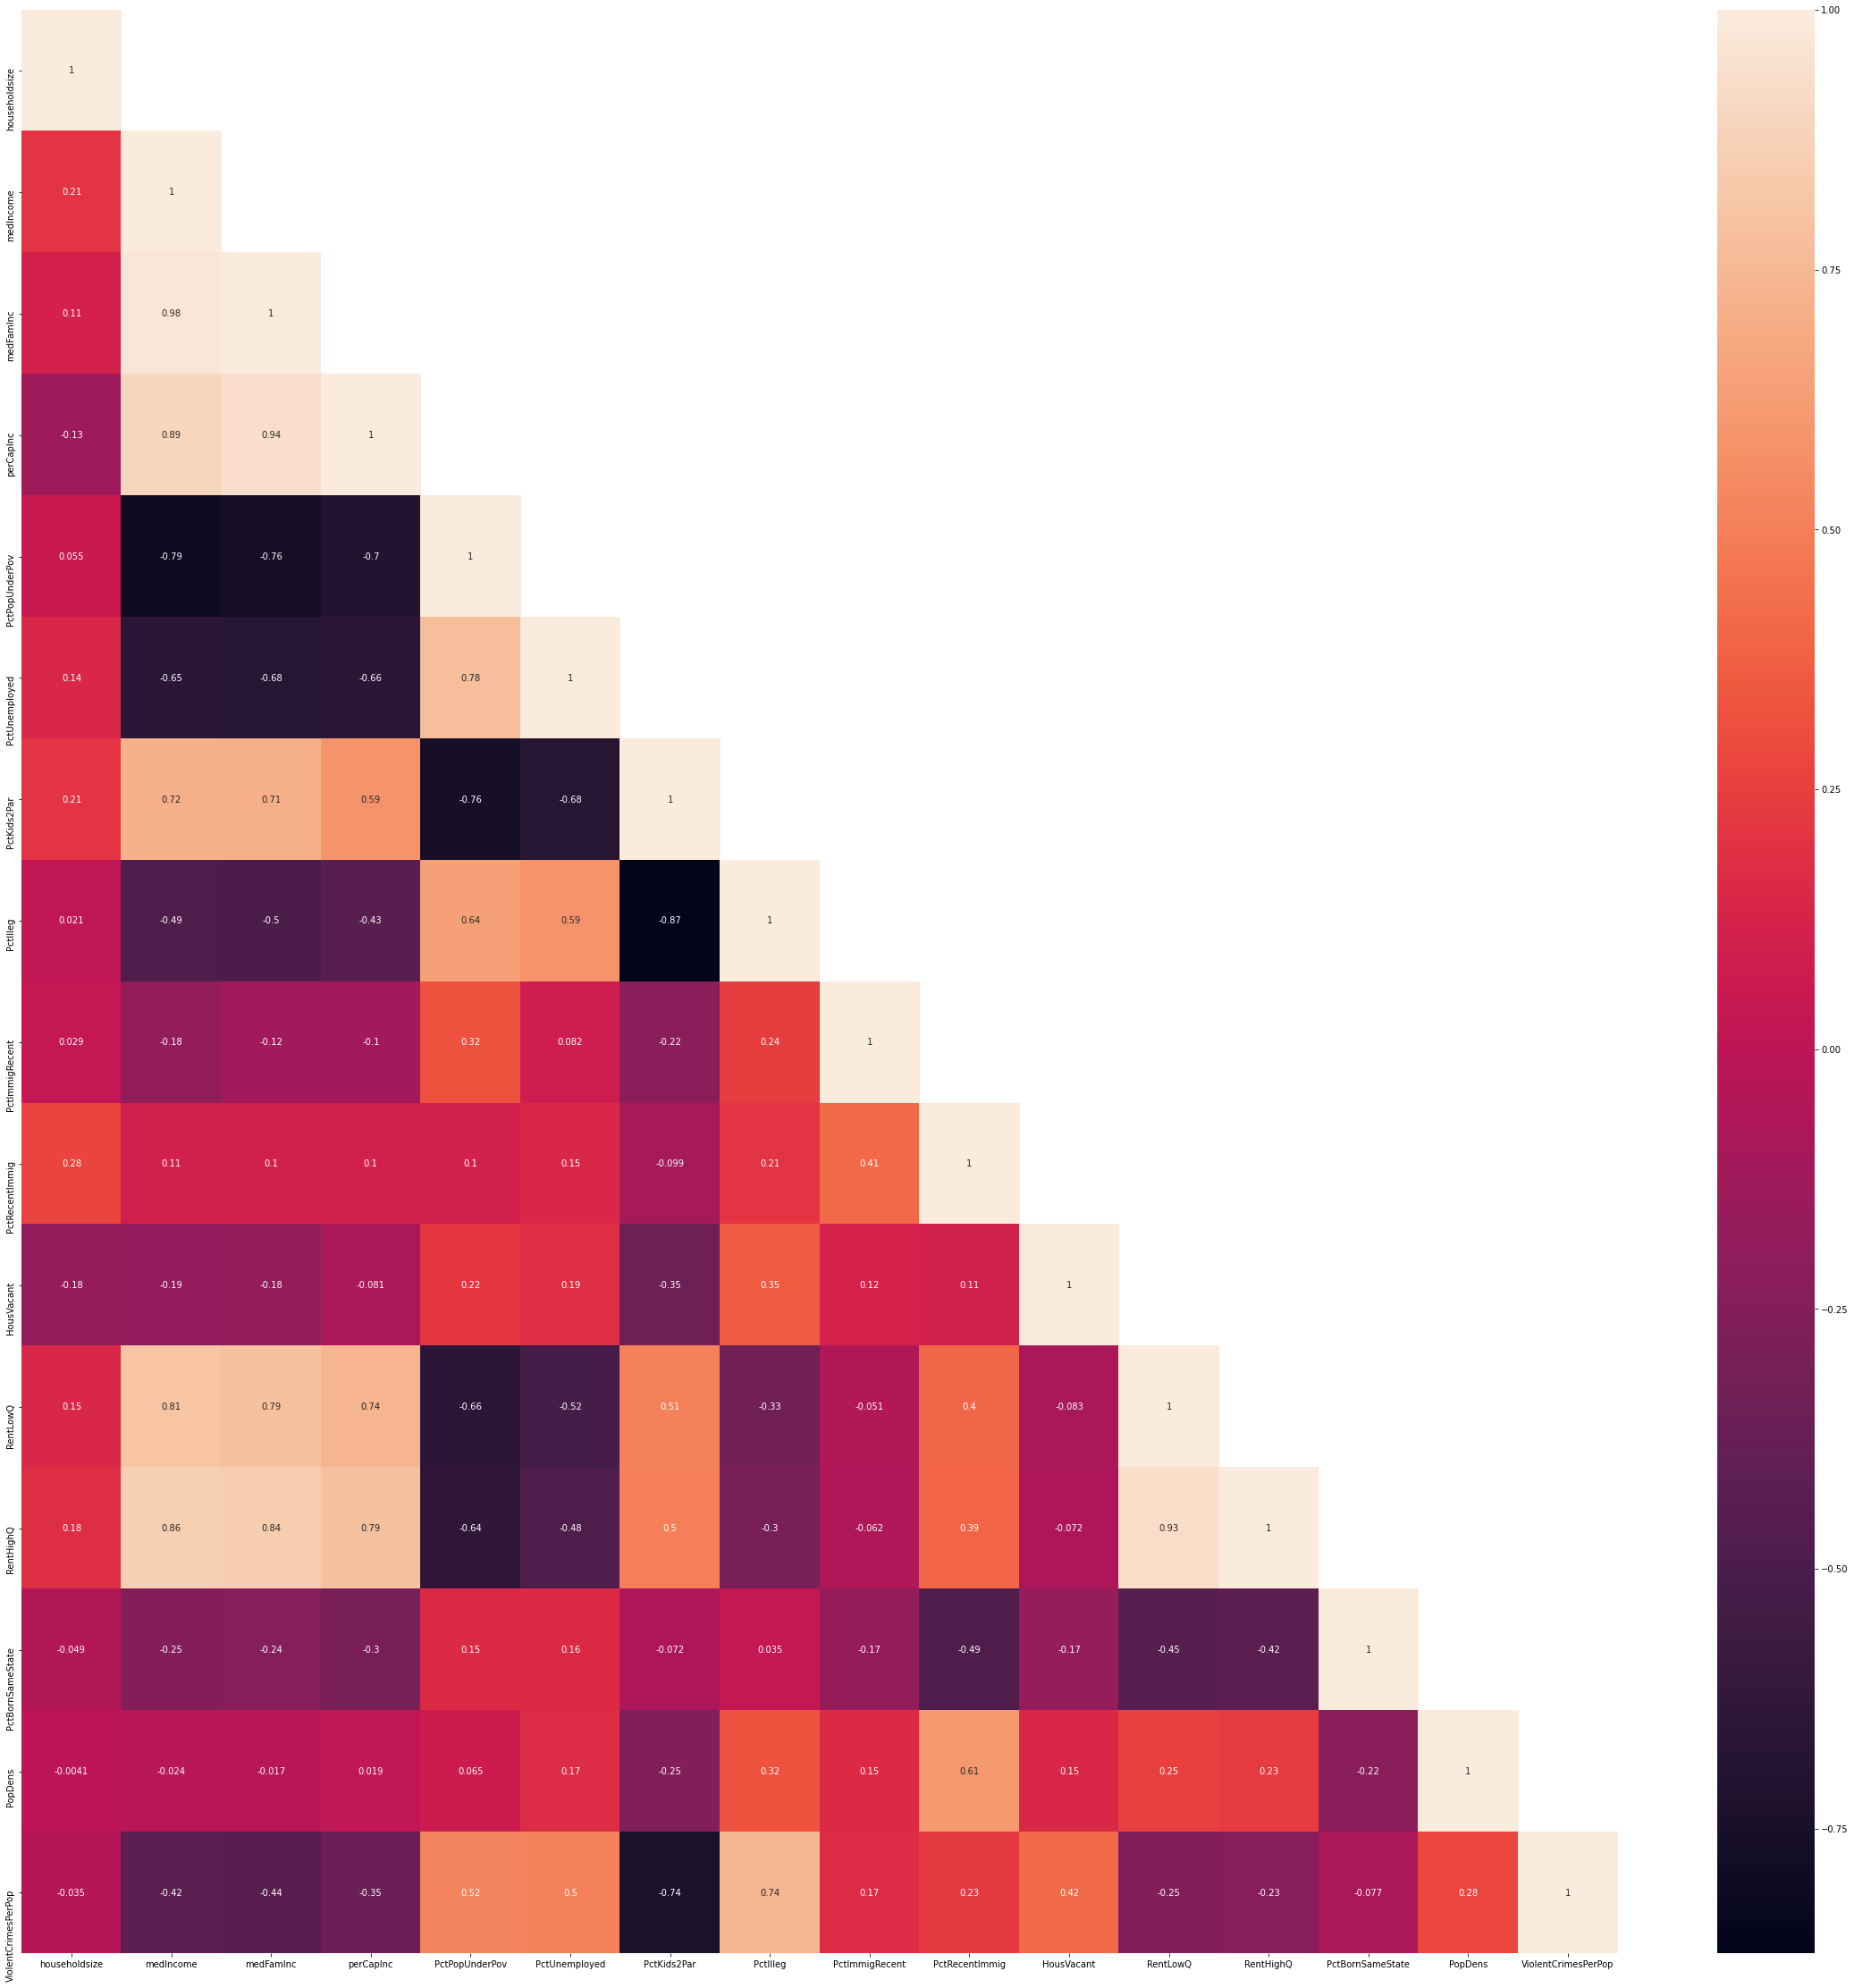

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(df_filtered.corr(),annot=True,mask=np.triu(df_filtered.corr(),+1))

## Observations:

* PctRecentImmig has high correlation with the features PctBornSameState(negative) and PopDens(positive).
This tells us that, it's likely to see higher Recent Immigrant percentages from the population whenever there's higher Population Density and a lower percentage of people born in the same state. This is a very obvious inference but still accounts for moderate correlation values which implies the other population except the Immigrants.

* RentHighQ and RentLowQ have a high correlation with a lot of features so, they should be considered to be dropped.

* PctIlleg has a high correlation with many features too.
  * It's highly likely that the Population which has kids before marriage has higher percentage of kids which won't have both parents.
  * It's moderate to highly likely that the Population which has kids before marriage is also unemployed and is under poverty.
  * It's moderately likely that the Population which has kids before marriage has lower per Capita Income, lower median Family Income as well as lower median Income.
* Percentage of kids with 2 parents is likely higher when the population is employed and is not under Poverty. Also, it's highly likely that the percentage of kids with 2 parents has a high per Capita Income or a higher median Family Income or higher median Income than the overall Population.
* The Percentage of Population under Poverty and Percentage of Population unemployed have a high correlation.
* The median Family Income, median Income and per Capita Income are highly correlated to each other and only a single effective feature should be considered when we have to predict.


## Bi-Variate Analysis to check on our Inferences

### PctIlleg and PctKids2Par

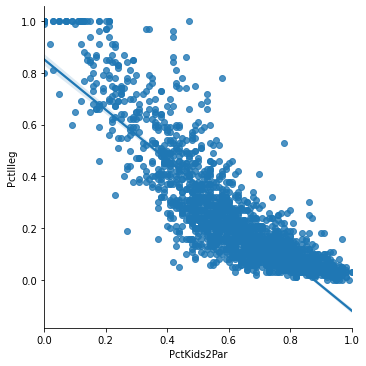

In [ ]:
sns.lmplot(x='PctKids2Par', y='PctIlleg', data=df_filtered)

### PctIlleg and PctUnemployed

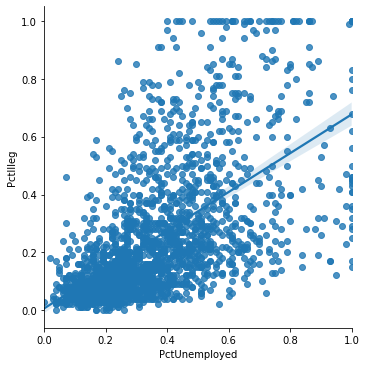

In [ ]:
sns.lmplot(x='PctUnemployed', y='PctIlleg', data=df_filtered)

###PctIlleg and PctPopUnderPov

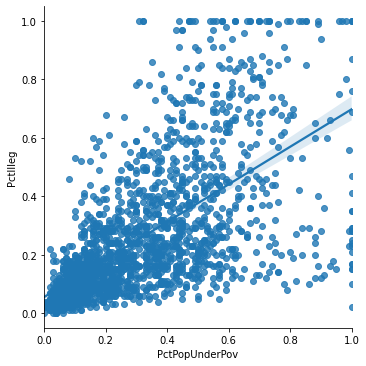

In [ ]:
sns.lmplot(x='PctPopUnderPov', y='PctIlleg', data=df_filtered)

### PctPopUnderPov and PctUnemployed

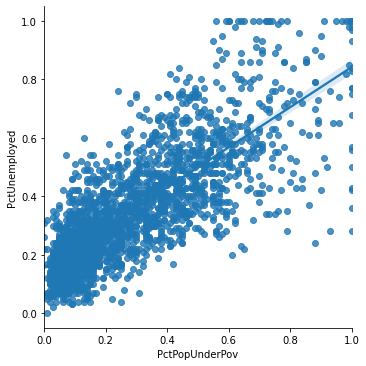

In [ ]:
sns.lmplot(x='PctPopUnderPov', y='PctUnemployed', data=df_filtered)

# Data Pre-Processing

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   householdsize        1994 non-null   float64
 1   medIncome            1994 non-null   float64
 2   medFamInc            1994 non-null   float64
 3   perCapInc            1994 non-null   float64
 4   PctPopUnderPov       1994 non-null   float64
 5   PctUnemployed        1994 non-null   float64
 6   PctKids2Par          1994 non-null   float64
 7   PctIlleg             1994 non-null   float64
 8   PctImmigRecent       1994 non-null   float64
 9   PctRecentImmig       1994 non-null   float64
 10  HousVacant           1994 non-null   float64
 11  RentLowQ             1994 non-null   float64
 12  RentHighQ            1994 non-null   float64
 13  PctBornSameState     1994 non-null   float64
 14  PopDens              1994 non-null   float64
 15  ViolentCrimesPerPop  1994 non-null   f

### Since we don't have any non-null rows, we don't need any imputations here. Also, since all the values in the data-set are pre-scaled, we don't need to perform any Feature Engineering step.

### Outliers Check

In [ ]:
df_outlier = df_filtered.copy()

In [ ]:
def remove_outlier(col):
  sorted(col)
  Q1, Q3 = np.percentile(col, [25, 75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5*IQR)
  upper_range = Q3 + (1.5*IQR)
  return lower_range, upper_range

In [ ]:
for column in df_outlier.drop('ViolentCrimesPerPop', axis=1).columns:
  if df_outlier[column].dtype!='object':
    lr, ur = remove_outlier(df_outlier[column])
    df_outlier[column] = np.where(df_outlier[column]>ur, ur, df_outlier[column])
    df_outlier[column] = np.where(df_outlier[column]<lr, lr, df_outlier[column])

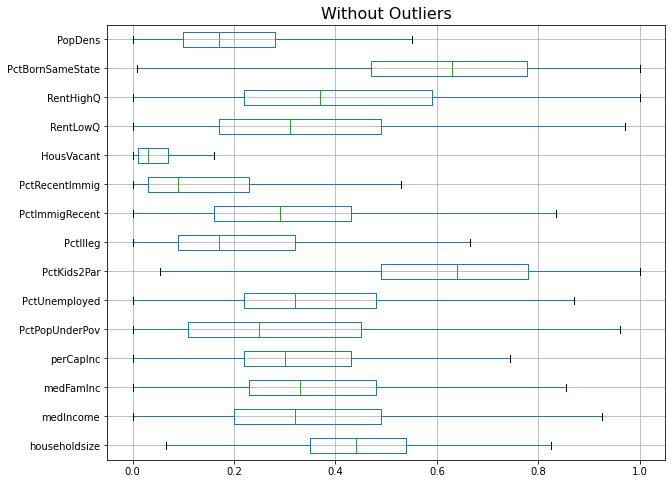

In [ ]:
#plotting boxplots after outlier treatment
plt.figure(figsize=(10,8))
plt.title('Without Outliers',fontsize=16)
df_outlier.drop('ViolentCrimesPerPop',axis=1).boxplot(vert=0)

# VIF (Variance Inflation Factor)

VIF detects multicollinearity in Regression Analysis.

**VIF = 1/(1-Ri^2)**

### With so many features having so many correlations, we need to filter them down to most predictive features using VIF Analysis.

In [ ]:
temp_df = df_outlier.copy()
temp_df_1 = temp_df.drop(['ViolentCrimesPerPop'], axis=1)
vif = pd.DataFrame()
vif['Features']=temp_df_1.columns
vif['VIF']=[variance_inflation_factor(temp_df_1.values,i) for i in range(temp_df_1.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

Features     VIF
2          medFamInc  233.01
1          medIncome  198.81
3          perCapInc   93.17
6        PctKids2Par   50.46
12         RentHighQ   49.85
0      householdsize   44.46
11          RentLowQ   31.92
4     PctPopUnderPov   17.33
13  PctBornSameState   15.98
5      PctUnemployed   14.90
7           PctIlleg   10.22
9     PctRecentImmig    6.25
8     PctImmigRecent    5.77
14           PopDens    5.48
10        HousVacant    2.96

### Observations:
* We can observe very high correlation values for the medFamInc and medIncome so they can be dropped as we can consider perCapInc.
* We need to drop RentHighQ and RentLowQ as we've seen in the Correlation Heatmap in EDA
* Since the PctPopUnderPov and PctUnemployed were also correlated, we can drop PctPopUnderPov

In [ ]:
temp_df = temp_df.drop(['perCapInc', 'medIncome', 'RentHighQ', 'RentLowQ', 'PctPopUnderPov'], axis=1)

In [ ]:
temp_df_1 = temp_df.drop(['ViolentCrimesPerPop'], axis=1)
vif = pd.DataFrame()
vif['Features']=temp_df_1.columns
vif['VIF']=[variance_inflation_factor(temp_df_1.values,i) for i in range(temp_df_1.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

Features    VIF
3       PctKids2Par  39.83
0     householdsize  17.34
1         medFamInc  15.52
8  PctBornSameState  14.97
2     PctUnemployed  10.47
4          PctIlleg   8.86
6    PctRecentImmig   5.49
9           PopDens   5.03
5    PctImmigRecent   4.78
7        HousVacant   2.78

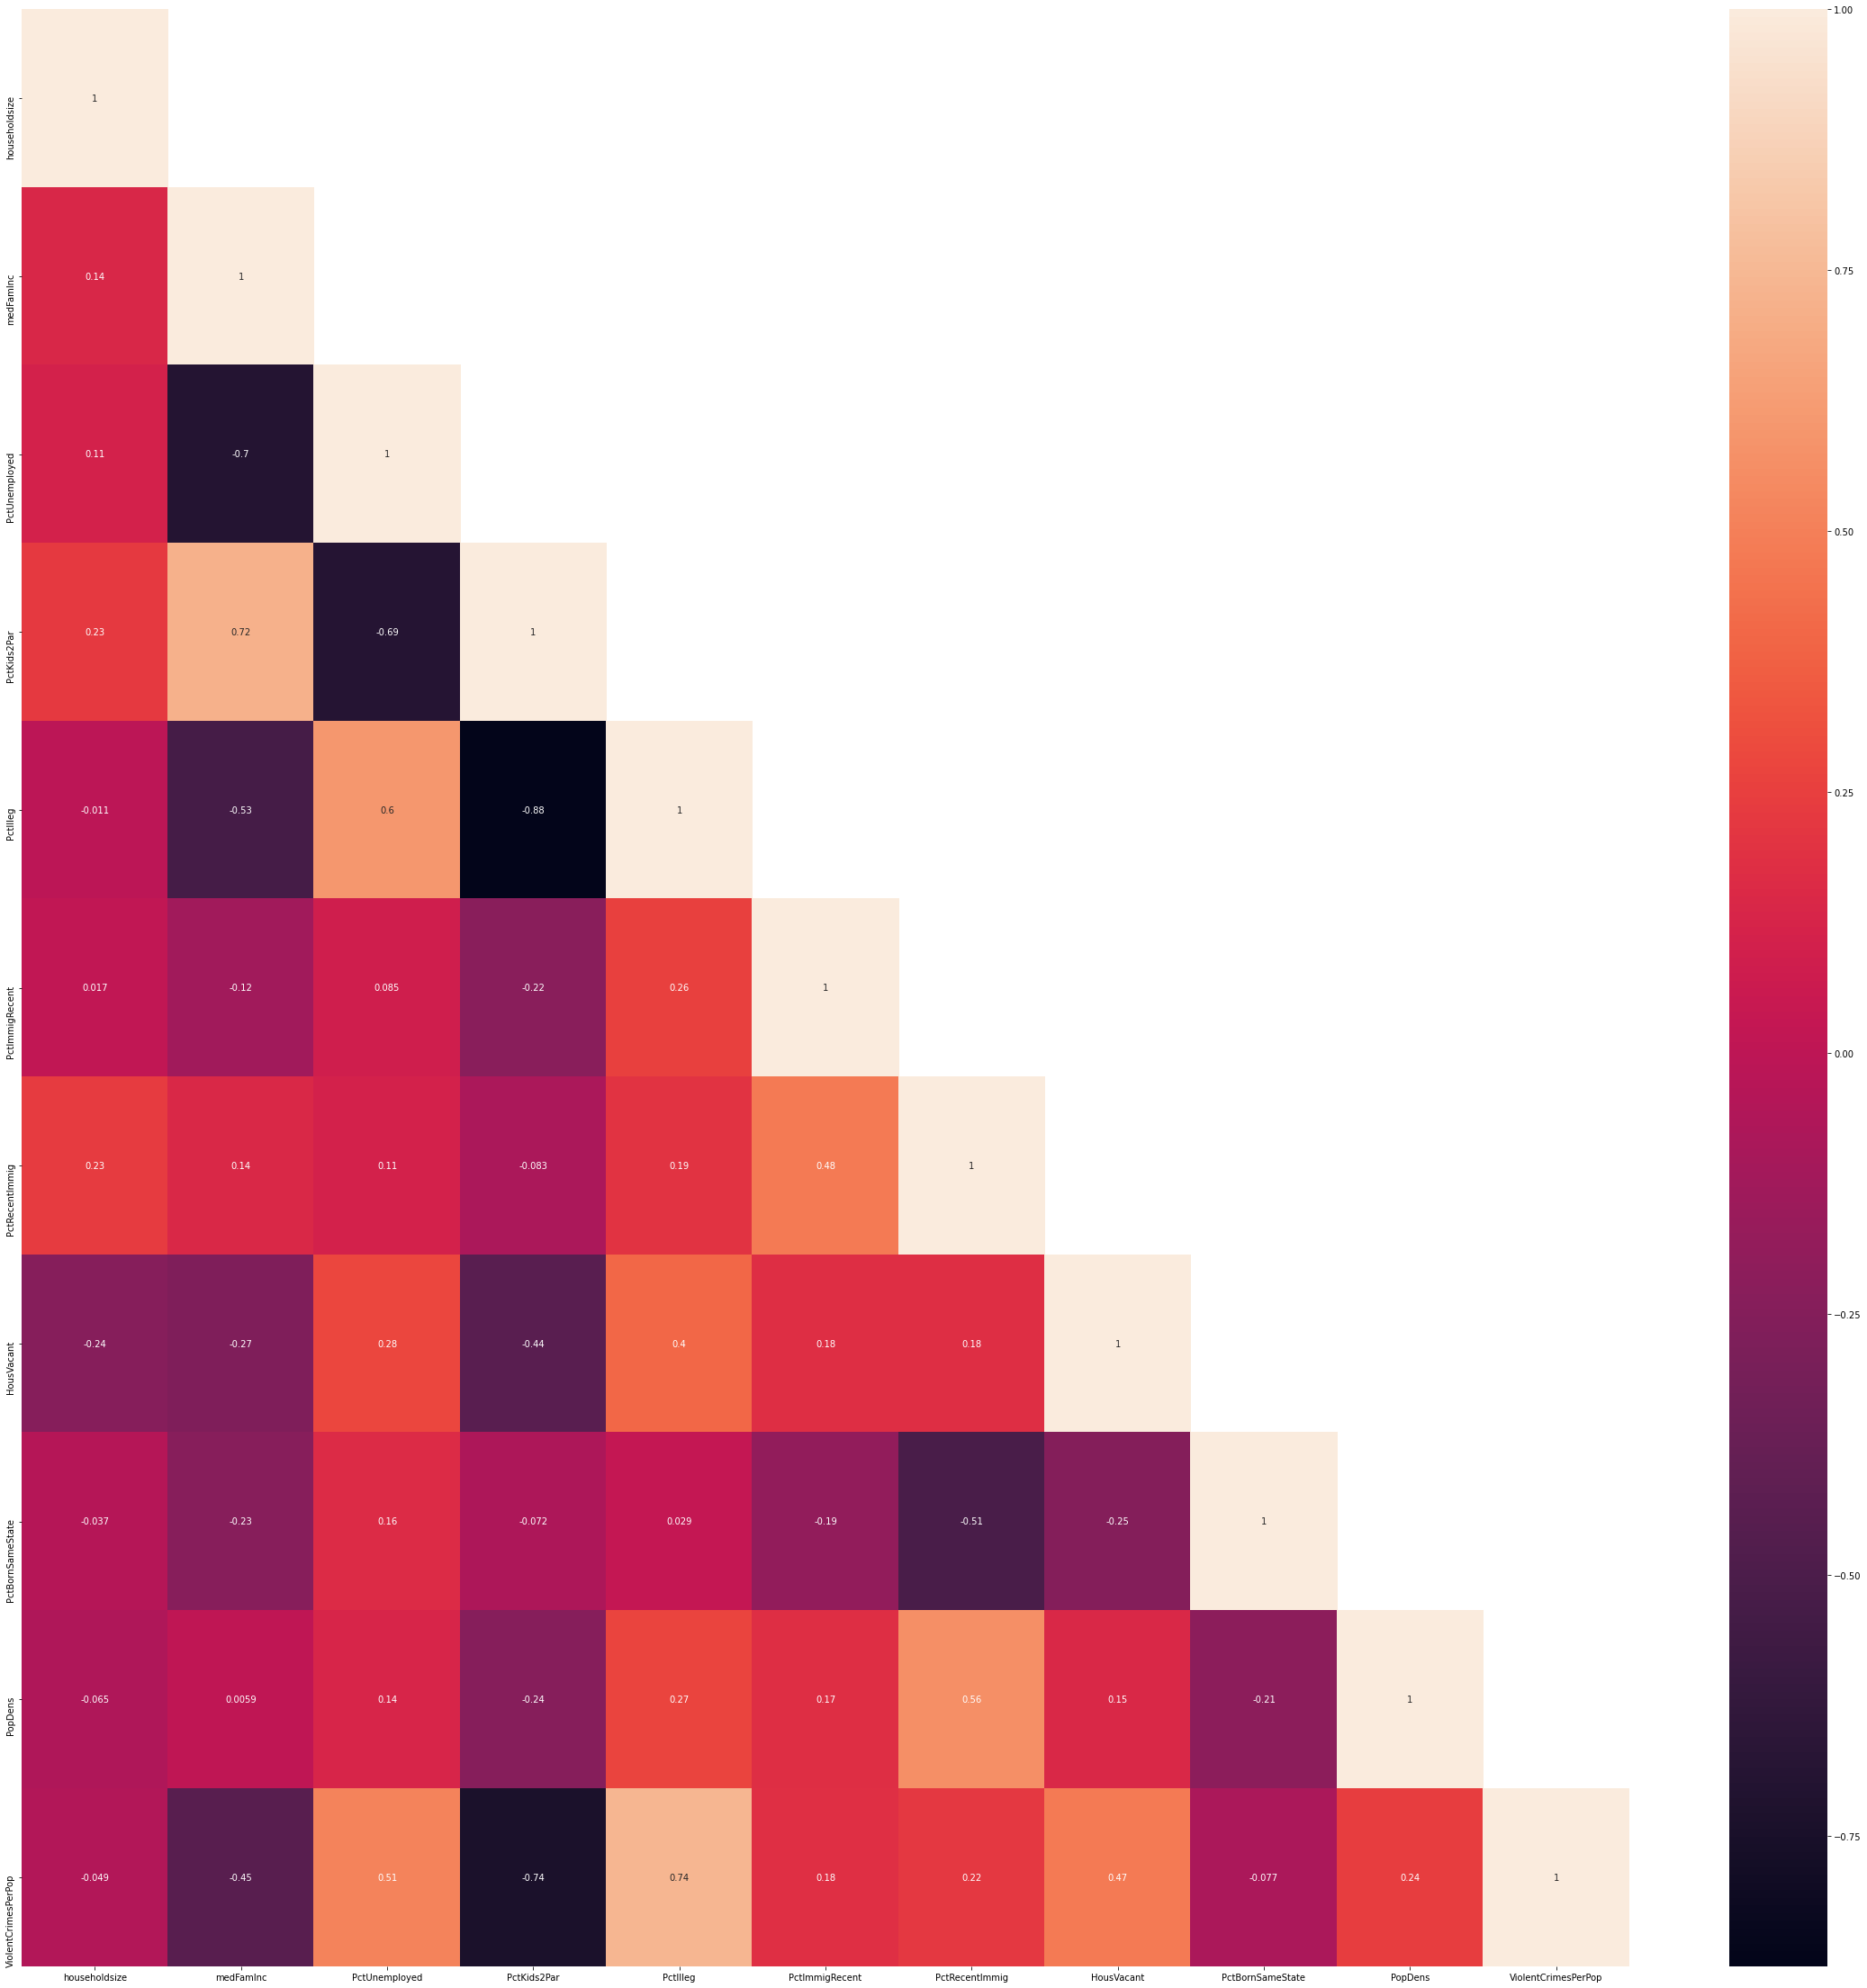

In [ ]:
plt.figure(figsize=(40,40))
sns.heatmap(temp_df.corr(),annot=True,mask=np.triu(temp_df.corr(),+1))

### Based on the correlation with our target variables and multicollinearity further, we choose PctBornSameState, householdsize and PctKids2Par variables to be dropped from our dataframe

In [ ]:
temp_df = temp_df.drop(['PctBornSameState', 'householdsize', 'PctKids2Par'], axis=1)

In [ ]:
temp_df_1 = temp_df.drop(['ViolentCrimesPerPop'], axis=1)
vif = pd.DataFrame()
vif['Features']=temp_df_1.columns
vif['VIF']=[variance_inflation_factor(temp_df_1.values,i) for i in range(temp_df_1.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by="VIF",ascending=False)
vif

Features   VIF
1   PctUnemployed  5.02
2        PctIlleg  4.91
6         PopDens  4.53
3  PctImmigRecent  4.03
4  PctRecentImmig  3.34
0       medFamInc  2.70
5      HousVacant  2.43

### As we can see, the VIF values of all features are <5 with one exception of PctUnemployed although, 5.02 is a considerable VIF value so, we'll consider it.

### We have obtained 7 powerful predictor columns.

In [ ]:
temp_df.head()

medFamInc  PctUnemployed  PctIlleg  ...  HousVacant  PopDens  ViolentCrimesPerPop
0       0.39           0.27      0.14  ...        0.16     0.26                 0.20
1       0.29           0.27      0.24  ...        0.02     0.12                 0.67
2       0.28           0.36      0.46  ...        0.01     0.21                 0.43
3       0.51           0.33      0.33  ...        0.01     0.39                 0.12
4       0.46           0.12      0.06  ...        0.01     0.09                 0.03

[5 rows x 8 columns]

## Train-Test Split of Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('ViolentCrimesPerPop', axis=1), temp_df.loc[:, 'ViolentCrimesPerPop'], test_size=0.3, random_state=1)

In [ ]:
type(y_test)

pandas.core.series.Series

## Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.score(X_test, y_test)

0.5874776289296706

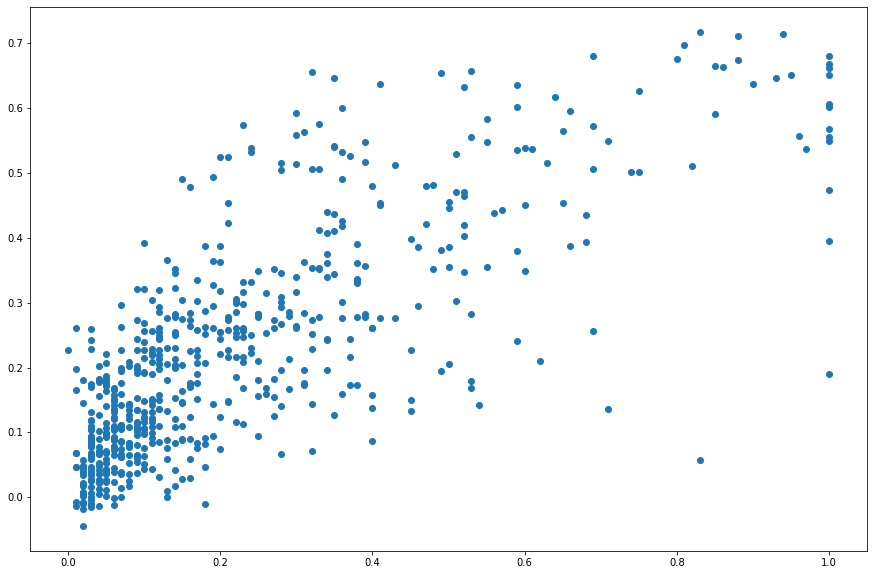

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(y_test, lr.predict(X_test))

### Using the statsmodel approach

In [ ]:
x_train = X_train.copy()
Y_train = y_train.copy()
x_test = X_test.copy()
Y_test = y_test.copy()

In [ ]:
x_train = sm.add_constant(x_train)

In [ ]:
est = sm.OLS(Y_train, x_train).fit()

In [ ]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.595
Model:                             OLS   Adj. R-squared:                  0.593
Method:                  Least Squares   F-statistic:                     291.2
Date:                 Thu, 29 Apr 2021   Prob (F-statistic):          5.46e-267
Time:                         11:16:41   Log-Likelihood:                 671.71
No. Observations:                 1395   AIC:                            -1327.
Df Residuals:                     1387   BIC:                            -1285.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0421      0.024      1.736      0.083      -0.005       0.090
medFamInc         -0.0993      0.034     -2.928      0.003      -0.166      -0.033
PctUnemployed      0.0491      0.033      1.496      0.135      -0.015       0.113
PctIlleg           0.7131      0.029     24.684      0.000       0.656       0.770
PctImmigRecent    -0.0607      0.023     -2.610      0.009      -0.106      -0.015
PctRecentImmig     0.1497      0.036      4.103      0.000       0.078       0.221
HousVacant         0.9029      0.091      9.879      0.000       0.724       1.082
PopDens           -0.0107      0.034     -0.310      0.756      -0.078       0.057
==============================================================================
Omnibus:                      210.735   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              452.703
Skew:                           0.875   Prob(JB):                     4.98e-99
Kurtosis:                       5.174   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Normality of Residuals

In [ ]:
data_test = pd.concat([X_test, y_test], axis=1)
predict_test = est.predict(data_test)
data_test['Predicted_rate'] = predict_test

In [ ]:
data_test.head()

medFamInc  PctUnemployed  ...  ViolentCrimesPerPop  Predicted_rate
1746      0.855           0.04  ...                 0.06        0.481848
1556      0.210           0.41  ...                 0.37        0.236013
56        0.490           0.25  ...                 0.22        0.602913
1740      0.760           0.26  ...                 0.01        0.046713
913       0.550           0.33  ...                 0.16        0.673594

[5 rows x 9 columns]

In [ ]:
data_test['Residual'] = data_test['ViolentCrimesPerPop'] - data_test['Predicted_rate']

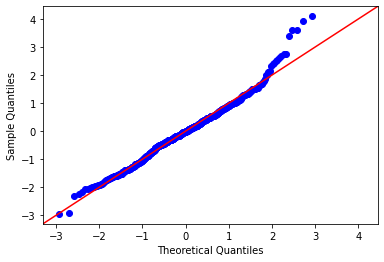

In [ ]:
x = sm.qqplot(data_test['Residual'], fit=True, line='45')
plt.show()

Observation:
The QQ plot suggests a high normality thus, a highly normal data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


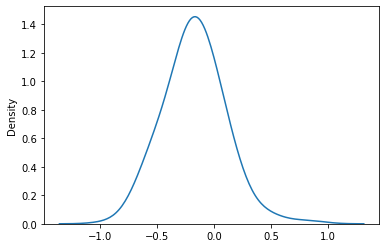

In [ ]:
sns.kdeplot(np.array(data_test['Residual']), bw=0.5)

In [ ]:
print( 'The Excess Kurtosis is: {}'.format( stats.kurtosis(data_test['Residual']) ))
print( 'Skewness : {}'.format( stats.skew(data_test['Residual']) ))

The Excess Kurtosis is: 1.1287173217740465
Skewness : 0.38604081291897513


The skewness is very low thus, it's a normal distribution and kurtosis as well, depicts a proper tails.

## Evaluation and Parameter Tuning

In [ ]:
# Function to check performance metrics
def check_performance(model):
  print("Train_R_squared =", model.best_estimator_.score(X_train, y_train)) 
  print("Test_R_squared =", model.best_estimator_.score(X_test, y_test))  
  print("RMSE_train =", np.sqrt(mean_squared_error(y_train, model.best_estimator_.predict(X_train))))
  print("RMSE_test = ", np.sqrt(mean_squared_error(y_test, model.best_estimator_.predict(X_test))))

# Ridge Regression

In [ ]:
ridge = Ridge(random_state=123)
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

### Grid-Search CV

In [ ]:
%%time
param_grid = {'alpha':list(range(0, 100))}
             
ridge = Ridge(random_state=123)

ridge_grid = GridSearchCV(estimator = ridge, param_grid = param_grid, cv = 3)

ridge_grid.fit(X_train,y_train)

CPU times: user 1.05 s, sys: 4.51 ms, total: 1.05 s
Wall time: 1.06 s


In [ ]:
ridge_grid.best_params_

{'alpha': 0}

In [ ]:
check_performance(ridge_grid)

Train_R_squared = 0.5950728525353459
Test_R_squared = 0.5874776289296706
RMSE_train = 0.14950123491952688
RMSE_test =  0.14649229106602132


### The Ridge Regression has alpha=0 so, it looks like we have OLS model again.

# ANNR Regression

In [ ]:
ANNR = MLPRegressor(random_state=123)
ANNR.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=123, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
%%time
param_grid = { 'hidden_layer_sizes':[(643,),(800,)], 
               "activation": ['tanh',"relu"]
             }

ANNR = MLPRegressor(max_iter=10000, random_state=123)

ANNR_grid = GridSearchCV(estimator = ANNR, param_grid = param_grid, cv = 3)

ANNR_grid.fit(X_train,y_train)

CPU times: user 11 s, sys: 7.55 s, total: 18.6 s
Wall time: 9.48 s


In [ ]:
ANNR_random.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (643,)}

In [ ]:
check_performance(ANNR_grid)

Train_R_squared = 0.6106695328197611
Test_R_squared = 0.6005518384286745
RMSE_train = 0.14659377492639017
RMSE_test =  0.1441521857538245


# All Models Performance

In [ ]:
%%time
LR = LinearRegression()
ridge = Ridge(random_state=123)
ANNR = MLPRegressor(random_state=123)
RFR = RandomForestRegressor(random_state=123)
DTR = DecisionTreeRegressor(random_state=123)
SV = SVR()

models=[LR,ridge,DTR,RFR,ANNR,SV]

rmse_train = []
rmse_test = []
scores_train = []
scores_test = []
MAPE_train = [] 
MAPE_test = []

for i in models:
      i.fit(X_train,y_train)
      scores_train.append(i.score(X_train, y_train))
      scores_test.append(i.score(X_test, y_test))
      rmse_train.append(np.sqrt(mean_squared_error(y_train,i.predict(X_train))))
      rmse_test.append(np.sqrt(mean_squared_error(y_test,i.predict(X_test))))

CPU times: user 1.19 s, sys: 438 ms, total: 1.63 s
Wall time: 1.2 s


In [ ]:
data = pd.DataFrame({'Train RMSE': rmse_train,'Test RMSE': rmse_test,'Train R-squared':scores_train,'Test R-squared': scores_test},
            index=['Linear Regression','Ridge Regression','Decision Tree Regressor','Random Forest Regressor', 'ANN Regressor', 'SVM Regressor'])
data

Train RMSE  ...  Test R-squared
Linear Regression        1.495012e-01  ...        0.587478
Ridge Regression         1.498763e-01  ...        0.582768
Decision Tree Regressor  5.942114e-18  ...        0.157346
Random Forest Regressor  5.668875e-02  ...        0.575809
ANN Regressor            1.481798e-01  ...        0.597064
SVM Regressor            1.366023e-01  ...        0.602142

[6 rows x 4 columns]

In [ ]:
SV.score(X_test, y_test)

0.6021416891364726

In [ ]:
SV.predict(np.array([0.7, 0.13, 0.1, 0.3, 0.4, 0.21, 0.37]).reshape(-1, 1).T)

array([0.22298289])

## We can say, SVM and ANNR fit the data better.